In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA

In [2]:
dataset = "HU"

In [3]:
df_means = pd.read_csv("master/outputs/cluster_means/%s_means.csv"%dataset)
df_emb = pd.read_csv("master/outputs/embeddings/%s_embedding.csv"%dataset)
df_edges = pd.read_csv("master/data/%s_edges.csv"%dataset, index_col="node_1")
df_emb.shape

(47538, 32)

In [4]:
with open('master/outputs/assignments/%s.json'%dataset) as json_file:  
    labels = json.load(json_file)
len(labels)

47538

In [5]:
df_label = pd.DataFrame({"index" : list(labels.keys()), "label" : list(labels.values())})
df_label["index"] = df_label["index"].astype(int)
df_label = df_label.set_index("index")
df_label = df_label.sort_index()
print(df_label.shape)
df_label.head()

(47538, 1)


,label
index,
0,19
1,29
2,31
3,3
4,7


### Diffusion Modeling

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
def cosine(x, y):
    return x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))

cosine(df_emb.iloc[1], df_emb.iloc[3])

-0.6559760878970629

In [8]:
def lookup_neighbor(i):
    if i in df_edges.index:
        if len(df_edges.loc[i]) == 1:
            return [df_edges.loc[i].node_2]
        return df_edges.loc[i].node_2
    return []

In [9]:
seeds = [1]

for seed in seeds: 
    neighbors = lookup_neighbor(seed)
    for nei in neighbors:
        print(seed, nei, cosine(df_emb.iloc[seed], df_emb.iloc[nei]))
        print( cosine_similarity(df_emb.iloc[seed].values.reshape(1, -1), df_emb.iloc[nei].values.reshape(1, -1))[0][0])# 

1 5463 0.7248175758314623
0.7248175758314624
1 14232 0.9922557608838273
0.9922557608838272
1 4833 0.9822202697303879
0.9822202697303881
1 36852 0.8673080885352024
0.8673080885352024
1 37620 0.9028622939607568
0.9028622939607567


### Random Seeds

In [10]:
len(df_label) / 100

475.38

In [11]:
n_seeds = 480

In [12]:
seeds = np.random.choice(df_emb.index, n_seeds)

def evaluate_seeds(seeds):
    df_label["index"] = df_label.index
    df_count= df_label.iloc[seeds].groupby("label").count().join(
        df_label.groupby("label").count(),
        lsuffix='_seed', rsuffix='_member'
    ).sort_values(["index_member"], ascending=False)
    df_count["pct"] = 100 * df_count.index_seed / df_count.index_member
    return df_count

evaluate_seeds(seeds)

,index_seed,index_member,pct
label,,,
7,16,2042,0.783546
26,16,1976,0.809717
16,15,1951,0.768836
23,17,1914,0.888192
24,13,1903,0.683132
3,19,1885,1.007958
2,24,1841,1.303639
30,16,1807,0.885445
18,13,1801,0.721821


### Influencers

In [13]:
df_influencer = df_edges.groupby("node_1").count()
seeds = df_influencer.sort_values(["node_2"], ascending=False)[:n_seeds].index.values

evaluate_seeds(seeds)

,index_seed,index_member,pct
label,,,
7,42,2042,2.056807
26,17,1976,0.860324
16,25,1951,1.281394
23,19,1914,0.992685
24,31,1903,1.629007
3,56,1885,2.970822
2,13,1841,0.706138
30,28,1807,1.549530
18,43,1801,2.387562


### Cluster Random Seeds

In [14]:
n_classes = len(np.unique(df_label.label))

In [15]:
seeds = []
for target in range(n_classes):
    df_cluster = df_label[df_label.label==target]
    cluster_n_seeds = round(n_seeds * len(df_cluster) / len(df_emb))
    seeds += list(np.random.choice(df_cluster.index, cluster_n_seeds, replace=False))

In [16]:
seeds = [int(i) for i in seeds]
evaluate_seeds(seeds)

,index_seed,index_member,pct
label,,,
7,21,2042,1.028404
26,20,1976,1.012146
16,20,1951,1.025115
23,19,1914,0.992685
24,19,1903,0.998424
3,19,1885,1.007958
2,19,1841,1.032048
30,18,1807,0.996126
18,18,1801,0.999445


### Cluster Influencer

In [17]:
seeds = []
for target in range(n_classes):
    idxs = df_label[df_label.label == target].index
    df_cluster = df_edges.loc[list(map(int, idxs))]
    cluster_n_seeds = round(n_seeds * len(df_cluster) / len(df_emb))
    
    df_influencer = df_cluster.groupby("node_1").count()
    
    cluster_seeds = list(df_influencer.sort_values(["node_2"], ascending=False)[:cluster_n_seeds].index.values)
    seeds += cluster_seeds

evaluate_seeds(seeds)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


,index_seed,index_member,pct
label,,,
7,118,2042,5.778648
26,89,1976,4.504049
16,104,1951,5.330600
23,99,1914,5.172414
24,106,1903,5.570152
3,124,1885,6.578249
2,90,1841,4.888647
30,98,1807,5.423354
18,116,1801,6.440866


### Stratified Sampling by Influence

In [18]:
df_influencer = df_edges.groupby("node_1").count().sort_values(["node_2"], ascending=False)
df_influencer["influence"] = 100 * df_influencer.node_2 / len(df_label)
len(df_influencer)

39772

In [19]:
df_influencer.head()

,node_2,influence
node_1,,
40491,96,0.201944
14900,73,0.153561
42470,63,0.132526
85,63,0.132526
33319,61,0.128318


In [20]:
print("%.2f%% don't have connection"%(100 * (1 - len(np.unique(df_edges.index)) / len(df_emb))))

16.34% don't have connection


In [21]:
print("%.2f%% unreachable"%(100 * (1 - len(np.unique(df_edges.node_2)) / len(df_emb))))

14.29% unreachable


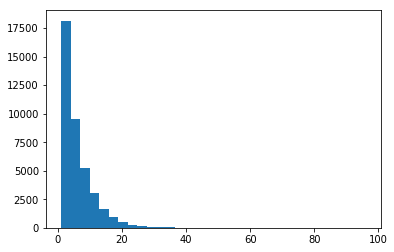

In [22]:
n_strata = 32
_ = plt.hist(df_influencer.node_2, bins=n_strata)
strata_size, strata_bound = _[0], _[1]

In [23]:
strata_sizes = list(map(round, strata_size))
strata_bounds = list(map(round, strata_bound))

In [24]:
seeds = []
for i in range(n_strata):
    l, r = strata_bounds[i], strata_bounds[i + 1]
    strata_size = int(strata_sizes[i])
    df_strata = df_influencer[(df_influencer.node_2 > l) & (df_influencer.node_2 < r)]
    cluster_n_seeds = round(n_seeds * strata_size / len(df_influencer))
    cluster_seeds = list(df_strata[:cluster_n_seeds].index.values)
    print("influence %i ~ %i, cluster size %i, seeds %i"
          %(l, r, strata_size, len(cluster_seeds)))
    
    seeds += cluster_seeds
print(len(seeds))

influence 1 ~ 4, cluster size 18145, seeds 219
influence 4 ~ 7, cluster size 9564, seeds 115
influence 7 ~ 10, cluster size 5228, seeds 63
influence 10 ~ 13, cluster size 3056, seeds 37
influence 13 ~ 16, cluster size 1691, seeds 20
influence 16 ~ 19, cluster size 905, seeds 11
influence 19 ~ 22, cluster size 481, seeds 6
influence 22 ~ 25, cluster size 266, seeds 3
influence 25 ~ 28, cluster size 173, seeds 2
influence 28 ~ 31, cluster size 88, seeds 1
influence 31 ~ 34, cluster size 48, seeds 1
influence 34 ~ 37, cluster size 41, seeds 0
influence 37 ~ 40, cluster size 25, seeds 0
influence 40 ~ 43, cluster size 18, seeds 0
influence 43 ~ 46, cluster size 8, seeds 0
influence 46 ~ 48, cluster size 12, seeds 0
influence 48 ~ 51, cluster size 5, seeds 0
influence 51 ~ 54, cluster size 5, seeds 0
influence 54 ~ 57, cluster size 5, seeds 0
influence 57 ~ 60, cluster size 3, seeds 0
influence 60 ~ 63, cluster size 3, seeds 0
influence 63 ~ 66, cluster size 0, seeds 0
influence 66 ~ 69, cl

In [25]:
evaluate_seeds(seeds)

,index_seed,index_member,pct
label,,,
7,34,2042,1.665034
26,19,1976,0.961538
16,16,1951,0.820092
23,19,1914,0.992685
24,18,1903,0.945875
3,22,1885,1.167109
2,17,1841,0.923411
30,18,1807,0.996126
18,14,1801,0.777346
